# Image Caption Generation

## Preparing Text and Images

### Preparing the Text
The dataset contains multiple descriptions for each photograph and the text of the descriptions requires some minimal cleaning.

First, we will load the file containing all of the descriptions. Function *load_doc*

Each photo has a unique identifier. This is used in the photo filename and in the text file of descriptions. Next, we will step through the list of photo descriptions and save the first description for each photo. Below defines a function named *load_descriptions()* that, given the loaded document text, will return a dictionary of photo identifiers to descriptions.

Next, we need to clean the description text.

The descriptions are already tokenized and easy to work with. We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

1. Convert all words to lowercase.
2. Remove all punctuation.
3. Remove all words that are one character or less in length (e.g. ‘a’).

Below defines the *clean_descriptions()* function that, given the dictionary of image identifiers to descriptions, steps through each description and cleans the text.

Finally, we save the dictionary of image identifiers and descriptions to a new file named *descriptions.txt*, with one image identifier and description per line.

Below defines the *save_doc()* function that given a dictionary containing the mapping of identifiers to descriptions and a filename, saves the mapping to file.

In [1]:
import string

# load doc in memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    #process lines
    for line in doc.split('\n'):
        #split line by white spaces
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        #remove filename from the image id
        image_id = image_id.split('.')[0]
        #convert the decsription token back to the string
        image_desc = ' '.join(image_desc)
        #store the first description for ecah image
        if image_id not in mapping:
            mapping[image_id] = image_desc
    return mapping

def clean_descriptions(descriptions):
    #prepare the transaltion table for removing the punctuation
    table = str.maketrans('','',string.punctuation)
    for key, desc in descriptions.items():
        #tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation for each token
        desc = [w.translate(table) for w in desc]
        # remove hanging a and s 
        desc = [word for word in desc if len(word)>1]
        # store the string
        descriptions[key] = ' '.join(desc)

#save descritions to file, one per line
def save_doc(descriptions, filename):
    lines = list()
    for key, desc in descriptions.items():
        lines.append(key + ' ' +desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
all_tokens = ' '.join(descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))
# save descriptions
save_doc(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 4484


### Preparing Image

We will use a pre-trained model to interpret the content of the photos.

There are many models to choose from. In this case, we will use the Oxford Visual Geometry Group or VGG model that won the ImageNet competition in 2014. Learn more about the model here:

[Very Deep Convolutional Networks for Large-Scale Visual Recognition](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)

Keras provides this pre-trained model directly. Note, the first time you use this model, Keras will download the model weights from the Internet, which are about 500 Megabytes. This may take a few minutes depending on your internet connection.

We could use this model as part of a broader image caption model. The problem is, it is a large model and running each photo through the network every time we want to test a new language model configuration (downstream) is redundant.

Instead, we can pre-compute the “photo features” using the pre-trained model and save them to file. We can then load these features later and feed them into our model as the interpretation of a given photo in the dataset. It is no different to running the photo through the full VGG model, it is just that we will have done it once in advance.

This is an optimization that will make training our models faster and consume less memory.

We can load the VGG model in Keras using the VGG class. We will load the model without the top; this means without the layers at the end of the network that are used to interpret the features extracted from the input and turn them into a class prediction. We are not interested in the image net classification of the photos and we will train our own interpretation of the image features.

Keras also provides tools for reshaping the loaded photo into the preferred size for the model (e.g. 3 channel 224 x 224 pixel image).

Below is a function named extract_features() that given a directory name will load each photo, prepare it for VGG and collect the predicted features from the VGG model. The image features are a 3-dimensional array with the shape (7, 7, 512).

The function returns a dictionary of image identifier to image features.

In [2]:
from os import listdir
from pickle import dump
from pickle import load
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input

# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    in_layer = Input(shape=(224, 224, 3))
    model = VGG16(include_top=False, input_tensor=in_layer)
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features

# extract features from images
# directory = 'Flicker8k_Dataset/Flicker8k_Dataset'
# features = extract_features(directory)
features = load(open('features-rnd.pkl', 'rb'))
print('Extracted Features: %d' %len(features))
# save file in pickle
# dump(features, open('features-rnd.pkl','wb'))

Using TensorFlow backend.


Extracted Features: 8091


## Baseline Caption Generation Model

In this section, we will define a baseline model for generating captions for photos and how to evaluate it so that it can be compared to variations on this baseline.

This section is divided into 5 parts:

1. Load Data.
2. Fit Model.
3. Evaluate Model.
4. Complete Example
5. “A” versus “A” Test
6. Generate Photo Captions

### 1. Load Data
We are not going to fit the model on all of the caption data, or even on a large sample of the data.

In this tutorial, we are interested in quickly testing a suite of different configurations of a caption model to see what works on this data. That means we need the evaluation of one model configuration to happen quickly. Toward this end, we will train the models on 100 photographs and captions, then evaluate them on both the training dataset and on a new test set of 100 photographs and captions.

First, we need to load a pre-defined subset of photographs. The provided dataset has separate sets for train, test, and development, which are really just different groups of photo identifiers. We will load the development set and use the first 100 identifiers for train and the second 100 (e.g. from 100 to 200) as the test set.

The function *load_set()* below will load a pre-defined set of identifiers, and we will call it with the *Flickr_8k.devImages.txt* filename as an argument.

In [3]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

Next, we need to split the set into train and test sets.

We will start by ordering the identifiers by sorting them to ensure we always split them consistently across machines and runs, then take the first 100 for train and the next 100 for test.

The *train_test_split()* function below will create this split given the loaded set of identifiers as input.

In [4]:
# split a dataset into train/test elements
def train_test_split(dataset):
    # order keys so the split is consistent
    ordered = sorted(dataset)
    # return split dataset as two new sets
    return set(ordered[:100]), set(ordered[100:200])

Now, we can load the photo descriptions using the pre-defined set of train or test identifiers.

Below is the function *load_clean_descriptions()* that loads the cleaned text descriptions from ‘descriptions.txt‘ for a given set of identifiers and returns a dictionary of identifier to text.

The model we will develop will generate a caption given a photo, and the caption will be generated one word at a time. The sequence of previously generated words will be provided as input. Therefore, we will need a “first word” to kick-off the generation process and a ‘last word‘ to signal the end of the caption. We will use the strings *‘startseq‘* and *‘endseq‘* for this purpose.

In [5]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # store
            descriptions[image_id] = 'startseq ' + ' '.join(image_desc) + ' endseq'
    return descriptions

Next, we can load the photo features for a given dataset.

Below defines a function named *load_photo_features()* that loads the entire set of photo descriptions, then returns the subset of interest for a given set of photo identifiers. This is not very efficient as the loaded dictionary of all photo features is about 700 Megabytes. Nevertheless, this will get us up and running quickly.

Note, if you have a better approach, share it in the comments below.

In [6]:
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [7]:
# load dev set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
dataset = load_set(filename)
print('Dataset: %d' % len(dataset))
# train-test split
train, test = train_test_split(dataset)
print('Train=%d, Test=%d' % (len(train), len(test)))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions), len(test_descriptions)))
# photo features
train_features = load_photo_features('features-rnd.pkl', train)
test_features = load_photo_features('features-rnd.pkl', test)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))

Dataset: 1000
Train=100, Test=100
Descriptions: train=100, test=100
Photos: train=100, test=100


The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.

The first step in encoding the data is to create a consistent mapping from words to unique integer values. Keras provides the Tokenizer class that can learn this mapping from the loaded description data.

Below defines the *create_tokenizer()* that will fit a Tokenizer given the loaded photo description text.

In [8]:
from keras.preprocessing.text import Tokenizer
# fit the tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

#prepare tokenizer
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)        

Vocabulary Size: 4485


We can now encode the text.

Each description will be split into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained.

For example, the input sequence “little girl running in field” would be split into 6 input-output pairs to train the model:

|X1   |	X2 (text sequence)                          |y (word)|
|-----|---------------------------------------------|--------|
|photo|	startseq,                                   |little  |
|photo|	startseq, little,                           |girl    |
|photo|	startseq, little, girl,                     |running |
|photo|	startseq, little, girl, running,            |in      |
|photo|	startseq, little, girl, running, in,        |field   |
|photo|	startseq, little, girl, running, in, field, |endseq  |

Later when the model is used to generate descriptions, the generated words will be concatenated and recursively provided as input to generate a caption for an image.

The function below named *create_sequences()* given the tokenizer, a single clean description, the features for a photo, and the maximum description length will prepare a set of input-output pairs for training a model. Calling this function will return X1 and X2 for the arrays of image data and input sequence data and the y value for the output word.

The input sequences are integer encoded and the output word is one-hot encoded to represent the probability distribution of the expected word across the whole vocabulary of possible words.

In [9]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, desc, image, max_length):
    Ximages, XSeq, y = list(), list(),list()
    vocab_size = len(tokenizer.word_index) + 1
    # integer encode the description
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # select
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        Ximages.append(image)
        XSeq.append(in_seq)
        y.append(out_seq)
    # Ximages, XSeq, y = array(Ximages), array(XSeq), array(y)
    return [Ximages, XSeq, y]

## 2. Fit Model
The model is based on the example laid out in the paper [“Show and Tell: A Neural Image Caption Generator“, 2015.](https://arxiv.org/abs/1411.4555)

The model involves three parts:

1. Photo Feature Extractor. This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with a the VGG model (without the top) and will use the extracted features predicted by this model as input.
2. Sequence Processor. This is a word embedding layer for handling the text input, followed by an LSTM layer. The LSTM output is interpreted by a Dense layer one output at a time.
3. Interpreter (for lack of a better name). Both the feature extractor and sequence processor output a fixed-length vector that is the length of a maximum sequence. These are concatenated together and processed by an LSTM and Dense layer before a final prediction is made.
A conservative number of neurons is used in the base model. Specifically, a 128 Dense layer after the feature extractor, a 50-dimensionality word embedding followed by a 256 unit LSTM and 128 neuron Dense after the sequence processor, and finally a 500 unit LSTM followed by a 500 neuron Dense at the end of the network.

The model predicts a probability distribution across the vocabulary, therefore a softmax activation function is used and a categorical cross entropy loss function is minimized while fitting the network.

The function define_model() defines the baseline model, given the size of the vocabulary and the maximum length of photo descriptions. The Keras functional API is used to define the model as it provides the flexibility needed to define a model that takes two input streams and combines them.

In [10]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='baseline1-plot.png')
    return model

We will train the model using a data generator. This is strictly not required given that the captions and extracted photo features can probably fit into memory as a single dataset. Nevertheless, it is good practice for when you come to train the final model on the entire dataset.

A generator will yield a result when called. In Keras, it will yield a single batch of input-output samples that are used to estimate the error gradient and update the model weights.

The function data_generator() defines the data generator, given a dictionary of loaded photo descriptions, photo features, the tokenizer for integer encoding sequences, and the maximum sequence length in the dataset.

The generator loops forever and keeps yielding batches of input-output pairs when asked. We also have a n_step parameter that allows us to tune how many images worth of input-output pairs to generate for each batch. The average sequence has 10 words, that is 10 input-output pairs, and a good batch size might be 30 samples, which is about 2-to-3 images worth.

In [11]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length, n_step):
    # loop until we finish training
    while 1:
        # loop over photo identifiers in the dataset
        keys = list(descriptions.keys())
        for i in range(0, len(keys), n_step):
            Ximages, XSeq, y = list(), list(),list()
            for j in range(i, min(len(keys), i+n_step)):
                image_id = keys[j]
                # retrieve photo feature input
                image = features[image_id][0]
                # retrieve text input
                desc = descriptions[image_id]
                # generate input-output pairs
                in_img, in_seq, out_word = create_sequences(tokenizer, desc, image, max_length)
                for k in range(len(in_img)):
                    Ximages.append(in_img[k])
                    XSeq.append(in_seq[k])
                    y.append(out_word[k])
            # yield this batch of samples to the model
            yield [[array(Ximages), array(XSeq)], array(y)]

For these experiments, we will use 2 images per batch, 50 batches (or 100 images) per epoch, and 50 training epochs. You can experiment with different configurations in your own experiments.

## 3. Evaluate Model
Now that we know how to prepare the data and define a model, we must define a test harness to evaluate a given model.

We will evaluate a model by training it on the dataset, generating descriptions for all photos in the training dataset, evaluating those predictions with a cost function, and then repeating this evaluation process multiple times.

The outcome will be a distribution of skill scores for the model that we can summarize by calculating the mean and standard deviation. This is the preferred way to evaluate deep learning models. 

First, we need to be able to generate a description for a photo using a trained model.

This involves passing in the start description token ‘startseq‘, generating one word, then calling the model recursively with generated words as input until the end of sequence token is reached ‘endseq‘ or the maximum description length is reached.

The function below named generate_desc() implements this behavior and generates a textual description given a trained model, and a given prepared photo as input. It calls the function word_for_id() in order to map an integer prediction back to a word.

In [12]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

We will generate predictions for all photos in the training dataset and in the test dataset.

The function below named *evaluate_model()* will evaluate a trained model against a given dataset of photo descriptions and photo features. The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text.

In [13]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
    # calculate BLEU score
    bleu = corpus_bleu(actual, predicted)
    return bleu

BLEU scores are used in text translation for evaluating translated text against one or more reference translations. We do in fact have access to multiple reference descriptions for each image that we could compare to, but for simplicity, we will use the first description for each photo in the dataset (e.g. the cleaned version).

You can learn more about the BLEU score here:

[BLEU (bilingual evaluation understudy) on Wikipedia](https://en.wikipedia.org/wiki/BLEU)

The NLTK Python library implements the BLEU score calculation in the corpus_bleu() function. A higher score close to 1.0 is better, a score closer to zero is worse.

Finally, all we need to do is define, fit, and evaluate the model multiple times in a loop then report the final average score.

Ideally, we would repeat the experiment 30 times or more, but this will take too long for our small test harness. Instead, will evaluate the model 3 times. It will be faster, but the mean score will have higher variance.

In [14]:
from os import listdir
from numpy import array
from numpy import argmax
from pandas import DataFrame
from nltk.translate.bleu_score import corpus_bleu
from pickle import load
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Embedding
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D, GlobalAveragePooling2D

In [15]:
# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: %d' % max_length)

Description Length: 25


In [25]:
# define experiment
model_name = 'baseline1'
n_verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'baseline1-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=n_verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Description Length: 25
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_8 (GlobalM (None, 512)          0           input_15[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 25, 50)       224250      input_16[0][0]                   
______________________________________________________________________________________

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.052499 test=0.129957
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_9 (GlobalM (None, 512)          0           input_17[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 25, 50)       224250      input_18[0][0]                   
____________________________________________________________________________

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>2: train=0.034853 test=0.086743
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_10 (Global (None, 512)          0           input_19[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 25, 50)       224250      input_20[0][0]                   
____________________________________________________________________________

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### BLEU score table
|      |    train |    test |
|------|----------|---------|
|count | 3.000000 | 3.000000|
|mean  | 0.050482 | 0.078201|
|std   | 0.014724 | 0.056513|
|min   | 0.034853 | 0.017904|
|25%   | 0.043676 | 0.052323|
|50%   | 0.052499 | 0.086743|
|75%   | 0.058296 | 0.108350|
|max   | 0.064094 | 0.129957|

### Generate Photo Captions
We expect the model is under-trained and maybe even under provisioned, but can it generate any kind of readable text at all?

It is important that the baseline model have some modicum of capability so that we can relate the BLEU scores of the baseline to an idea of what kind of quality of descriptions are being generated.

Let’s train a single model and generate a few descriptions from the train and test sets as a sanity check.

Change the number of repeats to 1 and the name of the run to *‘baseline_generate‘*.

In [26]:
model_name = 'baseline_generate'
one_repeats = 1

Then update the *evaluate_model()* function to only evaluate the first 5 photos in the dataset and print the descriptions.

In [27]:
# evaluate the skill of the model
def evaluate_model_five(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc in descriptions.items():
        # generate descriptions
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
        print('Actual : %s'%desc)
        print('Predicted : %s' %yhat)
        if len(actual) >= 5:
            break
        # calculate the BLEU score
        bleu = corpus_bleu(actual, predicted)
        return bleu

In [28]:
# Re-run the example.
for i in range(one_repeats):
    
    # see results for the TRAIN set
    # TODO
    train_score = evaluate_model_five(model, train_descriptions, train_features, tokenizer, max_length)

    # see results on the TEST dataset
    # TODO
    test_score = evaluate_model_five(model, test_descriptions, test_features, tokenizer, max_length)
    
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))

Actual : startseq child and woman are at waters edge in big city endseq
Predicted : startseq of people are waters waters near in city city city city city city city city city city city city city city city city city city


/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Actual : startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted : startseq of in swinging is sword jumping bicycle is front is front is front is front is front is front is front is front is front
>1: train=0.662215 test=0.526640


## Network Size Parameters
In this section, we will see how gross variations to the network structure impact model skill.

We will look at the following aspects of the model size:
1. Size of the fixed-vector output from the ‘encoders’.
2. Size of the sequence encoder model.
3. Size of the language model.


### Size of the Fixed-Vector
In the baseline model, the photo feature extractor and the text sequence encoder both output a 128 element vector. These vectors are then concatenated to be processed by the language model.

The 128 element vector from each sub-model contains everything known about the input sequence and photo. We can vary the size of this vector to see if it impacts model skill

First, we can **decrease the size by half from 128 elements to 64 elements**.

In [29]:
# define the captioning model
def define_model(vocab_size, max_length):
    
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(64, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(64, activation='relu'))(emb3)
    
    # merge inputs
    merged = concatenate([fe3, emb4])
    
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_name = 'size_sm_fixed_vec'

Running this experiment will give us a set of BLEU scores.

In [30]:
verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'size_sm_fixed_vec-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Epoch 1/100
 - 16s - loss: 7.0975 - acc: 0.0426
Epoch 2/100
 - 13s - loss: 5.5609 - acc: 0.0552
Epoch 3/100
 - 15s - loss: 5.4550 - acc: 0.0489
Epoch 4/100
 - 14s - loss: 5.4076 - acc: 0.0610
Epoch 5/100
 - 14s - loss: 5.3715 - acc: 0.0610
Epoch 6/100
 - 14s - loss: 5.3339 - acc: 0.0632
Epoch 7/100
 - 13s - loss: 5.3205 - acc: 0.0720
Epoch 8/100
 - 14s - loss: 5.2014 - acc: 0.0789
Epoch 9/100
 - 13s - loss: 5.1589 - acc: 0.0793
Epoch 10/100
 - 13s - loss: 5.0954 - acc: 0.0812
Epoch 11/100
 - 13s - loss: 5.0367 - acc: 0.0822
Epoch 12/100
 - 13s - loss: 4.9917 - acc: 0.0847
Epoch 13/100
 - 13s - loss: 4.9791 - acc: 0.0799
Epoch 14/100
 - 13s - loss: 4.9497 - acc: 0.0755
Epoch 15/100
 - 13s - loss: 4.8993 - acc: 0.0778
Epoch 16/100
 - 13s - loss: 4.8527 - acc: 0.0885
Epoch 17/100
 - 13s - loss: 4.7829 - acc: 0.0856
Epoch 18/100
 - 13s - loss: 4.7074 - acc: 0.0832
Epoch 19/100
 - 13s - loss: 4.6290 - acc: 0.0894
Epoch 20/100
 - 13s - loss: 4.5303 - acc: 0.0924
Epoch 21/100
 - 13s - loss: 4

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.075113 test=0.094529
Epoch 1/100
 - 15s - loss: 7.0440 - acc: 0.0450
Epoch 2/100
 - 12s - loss: 5.6042 - acc: 0.0541
Epoch 3/100
 - 12s - loss: 5.4410 - acc: 0.0693
Epoch 4/100
 - 12s - loss: 5.3601 - acc: 0.0735
Epoch 5/100
 - 12s - loss: 5.2654 - acc: 0.0721
Epoch 6/100
 - 12s - loss: 5.2107 - acc: 0.0734
Epoch 7/100
 - 12s - loss: 5.1355 - acc: 0.0791
Epoch 8/100
 - 12s - loss: 5.0861 - acc: 0.0773
Epoch 9/100
 - 12s - loss: 5.0190 - acc: 0.0778
Epoch 10/100
 - 12s - loss: 4.9688 - acc: 0.0810
Epoch 11/100
 - 12s - loss: 4.9052 - acc: 0.0807
Epoch 12/100
 - 12s - loss: 4.7889 - acc: 0.0915
Epoch 13/100
 - 12s - loss: 4.6790 - acc: 0.0865
Epoch 14/100
 - 12s - loss: 4.5704 - acc: 0.0888
Epoch 15/100
 - 12s - loss: 4.4163 - acc: 0.0959
Epoch 16/100
 - 12s - loss: 4.3186 - acc: 0.0968
Epoch 17/100
 - 12s - loss: 4.2112 - acc: 0.0826
Epoch 18/100
 - 12s - loss: 4.0847 - acc: 0.0955
Epoch 19/100
 - 12s - loss: 4.0030 - acc: 0.1091
Epoch 20/100
 - 12s - loss: 3.8439 - acc: 0.1

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>2: train=0.080115 test=0.020442
Epoch 1/100
 - 15s - loss: 7.0697 - acc: 0.0457
Epoch 2/100
 - 12s - loss: 5.5563 - acc: 0.0612
Epoch 3/100
 - 12s - loss: 5.3860 - acc: 0.0745
Epoch 4/100
 - 12s - loss: 5.3012 - acc: 0.0719
Epoch 5/100
 - 12s - loss: 5.1845 - acc: 0.0793
Epoch 6/100
 - 12s - loss: 5.1176 - acc: 0.0793
Epoch 7/100
 - 12s - loss: 5.0335 - acc: 0.0812
Epoch 8/100
 - 12s - loss: 4.9590 - acc: 0.0803
Epoch 9/100
 - 12s - loss: 4.8838 - acc: 0.0838
Epoch 10/100
 - 12s - loss: 4.8981 - acc: 0.0783
Epoch 11/100
 - 12s - loss: 4.7327 - acc: 0.0835
Epoch 12/100
 - 12s - loss: 4.6794 - acc: 0.0727
Epoch 13/100
 - 12s - loss: 4.6102 - acc: 0.0893
Epoch 14/100
 - 12s - loss: 4.4654 - acc: 0.0880
Epoch 15/100
 - 12s - loss: 4.2754 - acc: 0.0925
Epoch 16/100
 - 12s - loss: 4.1146 - acc: 0.0987
Epoch 17/100
 - 12s - loss: 3.9607 - acc: 0.1241
Epoch 18/100
 - 12s - loss: 3.8333 - acc: 0.1184
Epoch 19/100
 - 12s - loss: 3.5637 - acc: 0.1361
Epoch 20/100
 - 12s - loss: 3.4268 - acc: 0.1

### BLEU score table
|      |    train |    test |
|------|----------|---------|
|count | 3.000000 | 3.000000|
|mean  | 0.086055 | 0.062126|
|std   | 0.014833 | 0.037905|
|min   | 0.075113 | 0.020442|
|25%   | 0.077614 | 0.045925|
|50%   | 0.080115 | 0.071407|
|75%   | 0.091526 | 0.082968|
|max   | 0.102938 | 0.094529|

We can also **double the size of the fixed-length vector from 128 to 256 units**.

In [31]:
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(256, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_name = 'size_lg_fixed_vec'

In [32]:
verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'size_lg_fixed_vec-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Epoch 1/100
 - 21s - loss: 7.0605 - acc: 0.0459
Epoch 2/100
 - 16s - loss: 5.6234 - acc: 0.0540
Epoch 3/100
 - 16s - loss: 5.4336 - acc: 0.0574
Epoch 4/100
 - 16s - loss: 5.3677 - acc: 0.0572
Epoch 5/100
 - 16s - loss: 5.3405 - acc: 0.0606
Epoch 6/100
 - 16s - loss: 5.3216 - acc: 0.0630
Epoch 7/100
 - 16s - loss: 5.3107 - acc: 0.0630
Epoch 8/100
 - 16s - loss: 5.3215 - acc: 0.0630
Epoch 9/100
 - 16s - loss: 5.3013 - acc: 0.0630
Epoch 10/100
 - 16s - loss: 5.2888 - acc: 0.0630
Epoch 11/100
 - 16s - loss: 5.2809 - acc: 0.0630
Epoch 12/100
 - 16s - loss: 5.2736 - acc: 0.0630
Epoch 13/100
 - 18s - loss: 5.2692 - acc: 0.0630
Epoch 14/100
 - 16s - loss: 5.2641 - acc: 0.0630
Epoch 15/100
 - 16s - loss: 5.2697 - acc: 0.0630
Epoch 16/100
 - 16s - loss: 5.2962 - acc: 0.0630
Epoch 17/100
 - 16s - loss: 5.3100 - acc: 0.0630
Epoch 18/100
 - 16s - loss: 5.2929 - acc: 0.0608
Epoch 19/100
 - 16s - loss: 5.2835 - acc: 0.0630
Epoch 20/100
 - 16s - loss: 5.2698 - acc: 0.0630
Epoch 21/100
 - 16s - loss: 5

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.493329 test=0.491720
Epoch 1/100
 - 18s - loss: 7.0667 - acc: 0.0414
Epoch 2/100
 - 16s - loss: 5.6120 - acc: 0.0516
Epoch 3/100
 - 16s - loss: 5.4611 - acc: 0.0565
Epoch 4/100
 - 16s - loss: 5.3836 - acc: 0.0610
Epoch 5/100
 - 16s - loss: 5.3470 - acc: 0.0618
Epoch 6/100
 - 16s - loss: 5.3296 - acc: 0.0630
Epoch 7/100
 - 16s - loss: 5.3154 - acc: 0.0630
Epoch 8/100
 - 16s - loss: 5.3013 - acc: 0.0630
Epoch 9/100
 - 16s - loss: 5.2903 - acc: 0.0630
Epoch 10/100
 - 16s - loss: 5.2811 - acc: 0.0630
Epoch 11/100
 - 16s - loss: 5.2742 - acc: 0.0630
Epoch 12/100
 - 16s - loss: 5.2658 - acc: 0.0630
Epoch 13/100
 - 16s - loss: 5.2624 - acc: 0.0630
Epoch 14/100
 - 16s - loss: 5.2517 - acc: 0.0630
Epoch 15/100
 - 16s - loss: 5.2440 - acc: 0.0630
Epoch 16/100
 - 16s - loss: 5.2358 - acc: 0.0630
Epoch 17/100
 - 16s - loss: 5.2273 - acc: 0.0630
Epoch 18/100
 - 16s - loss: 5.2203 - acc: 0.0630
Epoch 19/100
 - 16s - loss: 5.2102 - acc: 0.0630
Epoch 20/100
 - 16s - loss: 5.2018 - acc: 0.0

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>2: train=0.086027 test=0.085906
Epoch 1/100
 - 19s - loss: 7.0645 - acc: 0.0390
Epoch 2/100
 - 16s - loss: 5.6390 - acc: 0.0568
Epoch 3/100
 - 16s - loss: 5.4739 - acc: 0.0630
Epoch 4/100
 - 16s - loss: 5.3894 - acc: 0.0630
Epoch 5/100
 - 16s - loss: 5.3588 - acc: 0.0630
Epoch 6/100
 - 16s - loss: 5.3383 - acc: 0.0630
Epoch 7/100
 - 16s - loss: 5.3203 - acc: 0.0630
Epoch 8/100
 - 16s - loss: 5.3035 - acc: 0.0630
Epoch 9/100
 - 16s - loss: 5.2894 - acc: 0.0630
Epoch 10/100
 - 16s - loss: 5.3163 - acc: 0.0630
Epoch 11/100
 - 16s - loss: 5.2899 - acc: 0.0630
Epoch 12/100
 - 16s - loss: 5.2831 - acc: 0.0630
Epoch 13/100
 - 16s - loss: 5.2854 - acc: 0.0630
Epoch 14/100
 - 16s - loss: 5.2841 - acc: 0.0630
Epoch 15/100
 - 16s - loss: 5.2770 - acc: 0.0630
Epoch 16/100
 - 16s - loss: 5.2904 - acc: 0.0630
Epoch 17/100
 - 16s - loss: 5.2517 - acc: 0.0630
Epoch 18/100
 - 16s - loss: 5.2671 - acc: 0.0630
Epoch 19/100
 - 16s - loss: 5.2454 - acc: 0.0630
Epoch 20/100
 - 16s - loss: 5.2484 - acc: 0.0

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>3: train=0.022001 test=0.022292
          train      test
count  3.000000  3.000000
mean   0.200452  0.199972
std    0.255651  0.254655
min    0.022001  0.022292
25%    0.054014  0.054099
50%    0.086027  0.085906
75%    0.289678  0.288813
max    0.493329  0.491720


### BLEU scores table
|      |    train |     test|
|------|----------|---------|
|count | 3.000000 | 3.000000|
|mean  | 0.200452 | 0.199972|
|std   | 0.255651 | 0.254655|
|min   | 0.022001 | 0.022292|
|25%   | 0.054014 | 0.054099|
|50%   | 0.086027 | 0.085906|
|75%   | 0.289678 | 0.288813|
|max   | 0.493329 | 0.491720|

### Sequence Encoder Size
We can call the sub-model that interprets the input sequence of words generated so far as the sequence encoder.

First, we can try to see if decreasing the representational capacity of the sequence encoder impacts model skill. We can **reduce the number of memory units in the LSTM layer from 256 to 128**.

In [33]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(128, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_name = 'size_sm_seq_model'

In [34]:
verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'size_sm_seq_model-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Epoch 1/100
 - 16s - loss: 7.0777 - acc: 0.0428
Epoch 2/100
 - 13s - loss: 5.6050 - acc: 0.0566
Epoch 3/100
 - 13s - loss: 5.4457 - acc: 0.0622
Epoch 4/100
 - 13s - loss: 5.4096 - acc: 0.0602
Epoch 5/100
 - 13s - loss: 5.3675 - acc: 0.0630
Epoch 6/100
 - 13s - loss: 5.3292 - acc: 0.0656
Epoch 7/100
 - 13s - loss: 5.3230 - acc: 0.0711
Epoch 8/100
 - 13s - loss: 5.2678 - acc: 0.0754
Epoch 9/100
 - 13s - loss: 5.2184 - acc: 0.0734
Epoch 10/100
 - 13s - loss: 5.1838 - acc: 0.0671
Epoch 11/100
 - 13s - loss: 5.1326 - acc: 0.0733
Epoch 12/100
 - 13s - loss: 5.1119 - acc: 0.0719
Epoch 13/100
 - 13s - loss: 5.0824 - acc: 0.0760
Epoch 14/100
 - 13s - loss: 5.0469 - acc: 0.0749
Epoch 15/100
 - 13s - loss: 5.0376 - acc: 0.0762
Epoch 16/100
 - 13s - loss: 5.0000 - acc: 0.0726
Epoch 17/100
 - 13s - loss: 4.9818 - acc: 0.0713
Epoch 18/100
 - 13s - loss: 4.9697 - acc: 0.0785
Epoch 19/100
 - 13s - loss: 4.9477 - acc: 0.0733
Epoch 20/100
 - 13s - loss: 4.9242 - acc: 0.0788
Epoch 21/100
 - 13s - loss: 4

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.032238 test=0.118414
Epoch 1/100
 - 16s - loss: 7.0681 - acc: 0.0452
Epoch 2/100
 - 13s - loss: 5.6050 - acc: 0.0565
Epoch 3/100
 - 13s - loss: 5.4669 - acc: 0.0568
Epoch 4/100
 - 13s - loss: 5.3859 - acc: 0.0704
Epoch 5/100
 - 13s - loss: 5.3634 - acc: 0.0724
Epoch 6/100
 - 13s - loss: 5.2802 - acc: 0.0778
Epoch 7/100
 - 13s - loss: 5.2102 - acc: 0.0768
Epoch 8/100
 - 13s - loss: 5.1801 - acc: 0.0766
Epoch 9/100
 - 13s - loss: 5.1072 - acc: 0.0755
Epoch 10/100
 - 13s - loss: 5.0994 - acc: 0.0774
Epoch 11/100
 - 13s - loss: 5.0632 - acc: 0.0773
Epoch 12/100
 - 13s - loss: 5.0330 - acc: 0.0787
Epoch 13/100
 - 13s - loss: 4.9712 - acc: 0.0756
Epoch 14/100
 - 13s - loss: 4.9320 - acc: 0.0801
Epoch 15/100
 - 13s - loss: 4.8893 - acc: 0.0731
Epoch 16/100
 - 13s - loss: 4.8114 - acc: 0.0802
Epoch 17/100
 - 13s - loss: 4.7870 - acc: 0.0786
Epoch 18/100
 - 13s - loss: 4.7258 - acc: 0.0700
Epoch 19/100
 - 13s - loss: 4.7370 - acc: 0.0719
Epoch 20/100
 - 13s - loss: 4.6511 - acc: 0.0

 - 13s - loss: 1.5551 - acc: 0.5135
Epoch 68/100
 - 13s - loss: 1.4852 - acc: 0.5091
Epoch 69/100
 - 13s - loss: 1.4448 - acc: 0.5205
Epoch 70/100
 - 13s - loss: 1.4794 - acc: 0.5099
Epoch 71/100
 - 13s - loss: 1.4268 - acc: 0.5248
Epoch 72/100
 - 13s - loss: 1.3669 - acc: 0.5154
Epoch 73/100
 - 13s - loss: 1.4045 - acc: 0.5077
Epoch 74/100
 - 13s - loss: 1.4111 - acc: 0.5361
Epoch 75/100
 - 13s - loss: 1.3082 - acc: 0.5458
Epoch 76/100
 - 13s - loss: 1.2121 - acc: 0.5751
Epoch 77/100
 - 13s - loss: 1.2813 - acc: 0.5562
Epoch 78/100
 - 13s - loss: 1.2732 - acc: 0.5799
Epoch 79/100
 - 13s - loss: 1.1708 - acc: 0.5868
Epoch 80/100
 - 13s - loss: 1.1167 - acc: 0.6280
Epoch 81/100
 - 13s - loss: 1.1227 - acc: 0.6375
Epoch 82/100
 - 13s - loss: 1.0466 - acc: 0.6445
Epoch 83/100
 - 13s - loss: 1.0060 - acc: 0.6576
Epoch 84/100
 - 13s - loss: 1.0047 - acc: 0.6504
Epoch 85/100
 - 13s - loss: 0.9889 - acc: 0.6680
Epoch 86/100
 - 13s - loss: 0.9654 - acc: 0.6678
Epoch 87/100
 - 13s - loss: 0.903

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### BLUE scores table
|      |    train  |    test|
|------|-----------|--------|
|count | 3.000000  |3.000000|
|mean  | 0.058336  |0.080239|
|std   | 0.031476  |0.054218|
|min   | 0.032238  |0.018180|
|25%   | 0.040858  |0.061151|
|50%   | 0.049478  |0.104123|
|75%   | 0.071385  |0.111268|
|max   | 0.093293  |0.118414|

Going the other way, we can **double the number of LSTM layers from one to two and see if that makes a dramatic difference**.

In [15]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = LSTM(256, return_sequences=True)(emb3)
    emb5 = TimeDistributed(Dense(128, activation='relu'))(emb4)
    # merge inputs
    merged = concatenate([fe3, emb5])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_name = 'size_lg_seq_model'

In [16]:
verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'size_lg_seq_model-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Description Length: 25
Epoch 1/100
 - 33s - loss: 7.0698 - acc: 0.0480
Epoch 2/100
 - 18s - loss: 5.6266 - acc: 0.0581
Epoch 3/100
 - 17s - loss: 5.4509 - acc: 0.0552
Epoch 4/100
 - 17s - loss: 5.3979 - acc: 0.0630
Epoch 5/100
 - 17s - loss: 5.3572 - acc: 0.0630
Epoch 6/100
 - 18s - loss: 5.3378 - acc: 0.0630
Epoch 7/100
 - 17s - loss: 5.3080 - acc: 0.0630
Epoch 8/100
 - 17s - loss: 5.3122 - acc: 0.0630
Epoch 9/100
 - 18s - loss: 5.2613 - acc: 0.0652
Epoch 10/100
 - 17s - loss: 5.2481 - acc: 0.0673
Epoch 11/100
 - 17s - loss: 5.2623 - acc: 0.0736
Epoch 12/100
 - 21s - loss: 5.2081 - acc: 0.0772
Epoch 13/100
 - 19s - loss: 5.1825 - acc: 0.0780
Epoch 14/100
 - 20s - loss: 5.1298 - acc: 0.0741
Epoch 15/100
 - 19s - loss: 5.1119 - acc: 0.0766
Epoch 16/100
 - 20s - loss: 5.1045 - acc: 0.0782
Epoch 17/100
 - 18s - loss: 5.0456 - acc: 0.0800
Epoch 18/100
 - 18s - loss: 5.0348 - acc: 0.0754
Epoch 19/100
 - 18s - loss: 4.9667 - acc: 0.0843
Epoch 20/100
 - 18s - loss: 4.9336 - acc: 0.0796
Epoch 

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.068580 test=0.108476
Epoch 1/100
 - 19s - loss: 7.0957 - acc: 0.0494
Epoch 2/100
 - 17s - loss: 5.5917 - acc: 0.0596
Epoch 3/100
 - 18s - loss: 5.4500 - acc: 0.0643
Epoch 4/100
 - 17s - loss: 5.3851 - acc: 0.0680
Epoch 5/100
 - 17s - loss: 5.3610 - acc: 0.0712
Epoch 6/100
 - 18s - loss: 5.2998 - acc: 0.0711
Epoch 7/100
 - 17s - loss: 5.2425 - acc: 0.0718
Epoch 8/100
 - 17s - loss: 5.1816 - acc: 0.0776
Epoch 9/100
 - 17s - loss: 5.1749 - acc: 0.0778
Epoch 10/100
 - 18s - loss: 5.1315 - acc: 0.0792
Epoch 11/100
 - 17s - loss: 5.0854 - acc: 0.0800
Epoch 12/100
 - 17s - loss: 5.0602 - acc: 0.0813
Epoch 13/100
 - 18s - loss: 5.0944 - acc: 0.0786
Epoch 14/100
 - 17s - loss: 5.0568 - acc: 0.0821
Epoch 15/100
 - 17s - loss: 5.0396 - acc: 0.0809
Epoch 16/100
 - 17s - loss: 5.0027 - acc: 0.0825
Epoch 17/100
 - 18s - loss: 4.9382 - acc: 0.0810
Epoch 18/100
 - 17s - loss: 4.9668 - acc: 0.0763
Epoch 19/100
 - 17s - loss: 4.9577 - acc: 0.0832
Epoch 20/100
 - 17s - loss: 4.9664 - acc: 0.0

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>2: train=0.005131 test=0.500384
Epoch 1/100
 - 19s - loss: 7.1027 - acc: 0.0446
Epoch 2/100
 - 17s - loss: 5.5707 - acc: 0.0563
Epoch 3/100
 - 17s - loss: 5.4500 - acc: 0.0667
Epoch 4/100
 - 17s - loss: 5.4187 - acc: 0.0592
Epoch 5/100
 - 18s - loss: 5.3593 - acc: 0.0707
Epoch 6/100
 - 17s - loss: 5.3483 - acc: 0.0661
Epoch 7/100
 - 17s - loss: 5.2539 - acc: 0.0730
Epoch 8/100
 - 18s - loss: 5.1955 - acc: 0.0708
Epoch 9/100
 - 17s - loss: 5.1544 - acc: 0.0768
Epoch 10/100
 - 17s - loss: 5.1522 - acc: 0.0763
Epoch 11/100
 - 17s - loss: 5.0756 - acc: 0.0775
Epoch 12/100
 - 18s - loss: 5.0733 - acc: 0.0776
Epoch 13/100
 - 17s - loss: 5.0472 - acc: 0.0784
Epoch 14/100
 - 17s - loss: 5.0225 - acc: 0.0760
Epoch 15/100
 - 17s - loss: 4.9912 - acc: 0.0760
Epoch 16/100
 - 18s - loss: 5.0016 - acc: 0.0676
Epoch 17/100
 - 17s - loss: 4.9460 - acc: 0.0646
Epoch 18/100
 - 18s - loss: 4.9544 - acc: 0.0695
Epoch 19/100
 - 18s - loss: 4.9290 - acc: 0.0824
Epoch 20/100
 - 17s - loss: 4.8704 - acc: 0.0

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### BLEU scores table
|       |   train  |    test|
|-------|----------|--------|
|count  |3.000000  |3.000000|
|mean   |0.044207  |0.209427|
|std    |0.034184  |0.255880|
|min    |0.005131  |0.019423|
|25%    |0.032020  |0.063949|
|50%    |0.058909  |0.108476|
|75%    |0.063745  |0.304430|
|max    |0.068580  |0.500384|

We can also try to **increase the representational capacity of the word embedding by doubling it from 50-dimensions to 100-dimensions.**

In [17]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 100, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_name = 'size_em_seq_model'

In [18]:
verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'size_em_seq_model-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Epoch 1/100
 - 16s - loss: 7.0816 - acc: 0.0384
Epoch 2/100
 - 14s - loss: 5.5922 - acc: 0.0587
Epoch 3/100
 - 13s - loss: 5.4991 - acc: 0.0556
Epoch 4/100
 - 13s - loss: 5.4177 - acc: 0.0630
Epoch 5/100
 - 13s - loss: 5.3538 - acc: 0.0694
Epoch 6/100
 - 13s - loss: 5.2890 - acc: 0.0749
Epoch 7/100
 - 14s - loss: 5.2516 - acc: 0.0706
Epoch 8/100
 - 13s - loss: 5.2130 - acc: 0.0756
Epoch 9/100
 - 13s - loss: 5.1021 - acc: 0.0776
Epoch 10/100
 - 13s - loss: 5.0967 - acc: 0.0762
Epoch 11/100
 - 14s - loss: 5.0426 - acc: 0.0777
Epoch 12/100
 - 13s - loss: 5.0445 - acc: 0.0793
Epoch 13/100
 - 13s - loss: 5.0005 - acc: 0.0820
Epoch 14/100
 - 13s - loss: 4.9289 - acc: 0.0752
Epoch 15/100
 - 13s - loss: 4.9374 - acc: 0.0775
Epoch 16/100
 - 13s - loss: 4.8981 - acc: 0.0760
Epoch 17/100
 - 13s - loss: 4.9274 - acc: 0.0740
Epoch 18/100
 - 13s - loss: 4.8305 - acc: 0.0760
Epoch 19/100
 - 13s - loss: 4.7516 - acc: 0.0738
Epoch 20/100
 - 13s - loss: 4.7068 - acc: 0.0813
Epoch 21/100
 - 14s - loss: 4

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.094151 test=0.129000
Epoch 1/100
 - 15s - loss: 7.0672 - acc: 0.0482
Epoch 2/100
 - 13s - loss: 5.6212 - acc: 0.0549
Epoch 3/100
 - 13s - loss: 5.4564 - acc: 0.0551
Epoch 4/100
 - 13s - loss: 5.3928 - acc: 0.0618
Epoch 5/100
 - 13s - loss: 5.3656 - acc: 0.0630
Epoch 6/100
 - 13s - loss: 5.3300 - acc: 0.0630
Epoch 7/100
 - 13s - loss: 5.3128 - acc: 0.0630
Epoch 8/100
 - 13s - loss: 5.3157 - acc: 0.0630
Epoch 9/100
 - 14s - loss: 5.2821 - acc: 0.0704
Epoch 10/100
 - 13s - loss: 5.2230 - acc: 0.0745
Epoch 11/100
 - 13s - loss: 5.1899 - acc: 0.0768
Epoch 12/100
 - 13s - loss: 5.1343 - acc: 0.0769
Epoch 13/100
 - 13s - loss: 5.1114 - acc: 0.0756
Epoch 14/100
 - 13s - loss: 5.0610 - acc: 0.0751
Epoch 15/100
 - 13s - loss: 5.0387 - acc: 0.0795
Epoch 16/100
 - 13s - loss: 5.0103 - acc: 0.0763
Epoch 17/100
 - 13s - loss: 5.0151 - acc: 0.0783
Epoch 18/100
 - 14s - loss: 4.9446 - acc: 0.0765
Epoch 19/100
 - 13s - loss: 4.9442 - acc: 0.0773
Epoch 20/100
 - 13s - loss: 4.8620 - acc: 0.0

 - 14s - loss: 1.7319 - acc: 0.4416
Epoch 68/100
 - 15s - loss: 1.7128 - acc: 0.4675
Epoch 69/100
 - 13s - loss: 1.6908 - acc: 0.4704
Epoch 70/100
 - 13s - loss: 1.6306 - acc: 0.4926
Epoch 71/100
 - 14s - loss: 1.5895 - acc: 0.4740
Epoch 72/100
 - 14s - loss: 1.5373 - acc: 0.5065
Epoch 73/100
 - 14s - loss: 1.4898 - acc: 0.5180
Epoch 74/100
 - 13s - loss: 1.4748 - acc: 0.4932
Epoch 75/100
 - 13s - loss: 1.4967 - acc: 0.4977
Epoch 76/100
 - 13s - loss: 1.5082 - acc: 0.5044
Epoch 77/100
 - 13s - loss: 1.4385 - acc: 0.5249
Epoch 78/100
 - 13s - loss: 1.4902 - acc: 0.5318
Epoch 79/100
 - 13s - loss: 1.4354 - acc: 0.5318
Epoch 80/100
 - 13s - loss: 1.3421 - acc: 0.5634
Epoch 81/100
 - 14s - loss: 1.2671 - acc: 0.5813
Epoch 82/100
 - 13s - loss: 1.2576 - acc: 0.5810
Epoch 83/100
 - 14s - loss: 1.2285 - acc: 0.5763
Epoch 84/100
 - 13s - loss: 1.2303 - acc: 0.5922
Epoch 85/100
 - 13s - loss: 1.2418 - acc: 0.5806
Epoch 86/100
 - 13s - loss: 1.1761 - acc: 0.5886
Epoch 87/100
 - 13s - loss: 1.142

### BLEU scores table
|       |   train  |    test|
|-------|----------|--------|
|count  |3.000000  |3.000000|
|mean   |0.061488  |0.102689|
|std    |0.036364  |0.030017|
|min    |0.022305  |0.069993|
|25%    |0.045157  |0.089533|
|50%    |0.068009  |0.109073|
|75%    |0.081080  |0.119037|
|max    |0.094151  |0.129000|

### Size of Language Model
We can refer to the model that learns from the concatenated sequence and photo feature input as the language model. It is responsible for generating words.

First, we can look at the impact on model skill by **descresing the LSTM and dense layers from 500 to 256 neurons**.

In [19]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(256)(merged)
    lm3 = Dense(256, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_name = 'size_sm_lang_model'

In [20]:
verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'size_sm_lang_model-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Epoch 1/100
 - 11s - loss: 7.2896 - acc: 0.0504
Epoch 2/100
 - 9s - loss: 5.5627 - acc: 0.0586
Epoch 3/100
 - 9s - loss: 5.4075 - acc: 0.0630
Epoch 4/100
 - 9s - loss: 5.3386 - acc: 0.0630
Epoch 5/100
 - 9s - loss: 5.3084 - acc: 0.0648
Epoch 6/100
 - 9s - loss: 5.2449 - acc: 0.0739
Epoch 7/100
 - 9s - loss: 5.1872 - acc: 0.0723
Epoch 8/100
 - 9s - loss: 5.1436 - acc: 0.0755
Epoch 9/100
 - 9s - loss: 5.1011 - acc: 0.0768
Epoch 10/100
 - 9s - loss: 5.0744 - acc: 0.0702
Epoch 11/100
 - 9s - loss: 5.0357 - acc: 0.0748
Epoch 12/100
 - 9s - loss: 5.0087 - acc: 0.0792
Epoch 13/100
 - 9s - loss: 4.9605 - acc: 0.0792
Epoch 14/100
 - 9s - loss: 4.9315 - acc: 0.0817
Epoch 15/100
 - 9s - loss: 4.9110 - acc: 0.0769
Epoch 16/100
 - 9s - loss: 4.8957 - acc: 0.0825
Epoch 17/100
 - 9s - loss: 4.8959 - acc: 0.0827
Epoch 18/100
 - 9s - loss: 4.8502 - acc: 0.0849
Epoch 19/100
 - 9s - loss: 4.8272 - acc: 0.0755
Epoch 20/100
 - 9s - loss: 4.7982 - acc: 0.0833
Epoch 21/100
 - 9s - loss: 4.8002 - acc: 0.0805


/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.034838 test=0.015892
Epoch 1/100
 - 11s - loss: 7.3247 - acc: 0.0535
Epoch 2/100
 - 9s - loss: 5.5615 - acc: 0.0542
Epoch 3/100
 - 9s - loss: 5.4369 - acc: 0.0592
Epoch 4/100
 - 9s - loss: 5.3769 - acc: 0.0630
Epoch 5/100
 - 9s - loss: 5.3543 - acc: 0.0630
Epoch 6/100
 - 9s - loss: 5.3297 - acc: 0.0630
Epoch 7/100
 - 9s - loss: 5.3250 - acc: 0.0630
Epoch 8/100
 - 9s - loss: 5.3107 - acc: 0.0630
Epoch 9/100
 - 9s - loss: 5.2981 - acc: 0.0630
Epoch 10/100
 - 9s - loss: 5.2916 - acc: 0.0630
Epoch 11/100
 - 9s - loss: 5.2889 - acc: 0.0630
Epoch 12/100
 - 9s - loss: 5.2871 - acc: 0.0630
Epoch 13/100
 - 9s - loss: 5.3003 - acc: 0.0630
Epoch 14/100
 - 9s - loss: 5.2936 - acc: 0.0630
Epoch 15/100
 - 9s - loss: 5.2521 - acc: 0.0695
Epoch 16/100
 - 9s - loss: 5.2202 - acc: 0.0657
Epoch 17/100
 - 9s - loss: 5.2148 - acc: 0.0675
Epoch 18/100
 - 9s - loss: 5.1589 - acc: 0.0695
Epoch 19/100
 - 9s - loss: 5.1410 - acc: 0.0747
Epoch 20/100
 - 9s - loss: 5.0970 - acc: 0.0750
Epoch 21/100
 -

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>2: train=0.005278 test=0.087785
Epoch 1/100
 - 11s - loss: 7.2838 - acc: 0.0392
Epoch 2/100
 - 9s - loss: 5.5564 - acc: 0.0641
Epoch 3/100
 - 9s - loss: 5.4067 - acc: 0.0630
Epoch 4/100
 - 9s - loss: 5.3500 - acc: 0.0630
Epoch 5/100
 - 9s - loss: 5.3488 - acc: 0.0630
Epoch 6/100
 - 9s - loss: 5.3072 - acc: 0.0668
Epoch 7/100
 - 9s - loss: 5.2760 - acc: 0.0750
Epoch 8/100
 - 9s - loss: 5.2203 - acc: 0.0700
Epoch 9/100
 - 9s - loss: 5.1830 - acc: 0.0685
Epoch 10/100
 - 9s - loss: 5.1416 - acc: 0.0714
Epoch 11/100
 - 9s - loss: 5.1057 - acc: 0.0745
Epoch 12/100
 - 9s - loss: 5.0907 - acc: 0.0749
Epoch 13/100
 - 9s - loss: 5.0824 - acc: 0.0730
Epoch 14/100
 - 9s - loss: 5.0615 - acc: 0.0765
Epoch 15/100
 - 9s - loss: 5.0633 - acc: 0.0719
Epoch 16/100
 - 9s - loss: 5.0166 - acc: 0.0791
Epoch 17/100
 - 9s - loss: 5.0219 - acc: 0.0779
Epoch 18/100
 - 9s - loss: 5.0444 - acc: 0.0758
Epoch 19/100
 - 9s - loss: 4.9990 - acc: 0.0763
Epoch 20/100
 - 9s - loss: 4.9692 - acc: 0.0749
Epoch 21/100
 -

### BLEU scores table
|       |  train   |   test  |
|-------|----------|--------|
|count  |3.000000  |3.000000|
|mean   |0.032532  |0.066773|
|std    |0.026177  |0.044286|
|min    |0.005278  |0.015892|
|25%    |0.020058  |0.051838|
|50%    |0.034838  |0.087785|
|75%    |0.046159  |0.092213|
|max    |0.057480  |0.096642|

We can also look at the impact of **doubling the capacity of the language model by adding a second LSTM layer of the same size.**

In [21]:


# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500, return_sequences=True)(merged)
    lm3 = LSTM(500)(lm2)
    lm4 = Dense(500, activation='relu')(lm3)
    outputs = Dense(vocab_size, activation='softmax')(lm4)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_name = 'size_lg_lang_model'

In [22]:
verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'size_lg_lang_model-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Epoch 1/100
 - 27s - loss: 7.1036 - acc: 0.0523
Epoch 2/100
 - 22s - loss: 5.5664 - acc: 0.0594
Epoch 3/100
 - 22s - loss: 5.3466 - acc: 0.0596
Epoch 4/100
 - 22s - loss: 5.2196 - acc: 0.0585
Epoch 5/100
 - 22s - loss: 5.1373 - acc: 0.0563
Epoch 6/100
 - 22s - loss: 5.0831 - acc: 0.0625
Epoch 7/100
 - 22s - loss: 5.0200 - acc: 0.0576
Epoch 8/100
 - 22s - loss: 4.9783 - acc: 0.0607
Epoch 9/100
 - 22s - loss: 4.9392 - acc: 0.0607
Epoch 10/100
 - 22s - loss: 4.9088 - acc: 0.0592
Epoch 11/100
 - 22s - loss: 4.8464 - acc: 0.0587
Epoch 12/100
 - 22s - loss: 4.8244 - acc: 0.0587
Epoch 13/100
 - 22s - loss: 4.7956 - acc: 0.0568
Epoch 14/100
 - 22s - loss: 4.7892 - acc: 0.0604
Epoch 15/100
 - 22s - loss: 4.7626 - acc: 0.0569
Epoch 16/100
 - 22s - loss: 4.7221 - acc: 0.0642
Epoch 17/100
 - 22s - loss: 4.7056 - acc: 0.0639
Epoch 18/100
 - 22s - loss: 4.6511 - acc: 0.0656
Epoch 19/100
 - 22s - loss: 4.6395 - acc: 0.0692
Epoch 20/100
 - 22s - loss: 4.6144 - acc: 0.0670
Epoch 21/100
 - 22s - loss: 4

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.006395 test=0.082561
Epoch 1/100
 - 25s - loss: 7.0994 - acc: 0.0507
Epoch 2/100
 - 22s - loss: 5.5491 - acc: 0.0592
Epoch 3/100
 - 22s - loss: 5.3447 - acc: 0.0613
Epoch 4/100
 - 23s - loss: 5.2161 - acc: 0.0633
Epoch 5/100
 - 24s - loss: 5.1559 - acc: 0.0643
Epoch 6/100
 - 23s - loss: 5.1039 - acc: 0.0634
Epoch 7/100
 - 23s - loss: 5.0431 - acc: 0.0569
Epoch 8/100
 - 23s - loss: 4.9871 - acc: 0.0601
Epoch 9/100
 - 23s - loss: 4.9638 - acc: 0.0496
Epoch 10/100
 - 23s - loss: 4.9094 - acc: 0.0534
Epoch 11/100
 - 22s - loss: 4.8791 - acc: 0.0647
Epoch 12/100
 - 22s - loss: 4.8507 - acc: 0.0686
Epoch 13/100
 - 23s - loss: 4.8157 - acc: 0.0658
Epoch 14/100
 - 22s - loss: 4.7694 - acc: 0.0687
Epoch 15/100
 - 22s - loss: 4.7507 - acc: 0.0678
Epoch 16/100
 - 22s - loss: 4.7132 - acc: 0.0684
Epoch 17/100
 - 22s - loss: 4.6336 - acc: 0.0725
Epoch 18/100
 - 22s - loss: 4.6166 - acc: 0.0767
Epoch 19/100
 - 22s - loss: 4.5998 - acc: 0.0766
Epoch 20/100
 - 22s - loss: 4.5367 - acc: 0.0

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>2: train=0.008303 test=0.020878
Epoch 1/100
 - 26s - loss: 7.0904 - acc: 0.0469
Epoch 2/100
 - 22s - loss: 5.5449 - acc: 0.0604
Epoch 3/100
 - 22s - loss: 5.3419 - acc: 0.0635
Epoch 4/100
 - 22s - loss: 5.2271 - acc: 0.0604
Epoch 5/100
 - 22s - loss: 5.1848 - acc: 0.0645
Epoch 6/100
 - 22s - loss: 5.1194 - acc: 0.0617
Epoch 7/100
 - 23s - loss: 5.0406 - acc: 0.0700
Epoch 8/100
 - 22s - loss: 4.9832 - acc: 0.0700
Epoch 9/100
 - 23s - loss: 4.9128 - acc: 0.0702
Epoch 10/100
 - 22s - loss: 4.8740 - acc: 0.0705
Epoch 11/100
 - 22s - loss: 4.8118 - acc: 0.0760
Epoch 12/100
 - 22s - loss: 4.7653 - acc: 0.0763
Epoch 13/100
 - 22s - loss: 4.7224 - acc: 0.0812
Epoch 14/100
 - 22s - loss: 4.6553 - acc: 0.0872
Epoch 15/100
 - 22s - loss: 4.5917 - acc: 0.0874
Epoch 16/100
 - 22s - loss: 4.5311 - acc: 0.0827
Epoch 17/100
 - 22s - loss: 4.4942 - acc: 0.0833
Epoch 18/100
 - 22s - loss: 4.4564 - acc: 0.0789
Epoch 19/100
 - 22s - loss: 4.4317 - acc: 0.0804
Epoch 20/100
 - 22s - loss: 4.5526 - acc: 0.0

### BLEU scores table
|       |   train  |    test|
|-------|----------|--------|
|count  |3.000000  |3.000000|
|mean   |0.017823  |0.035789|
|std    |0.018168  |0.041382|
|min    |0.006395  |0.003929|
|25%    |0.007349  |0.012403|
|50%    |0.008303  |0.020878|
|75%    |0.023538  |0.051719|
|max    |0.038773  |0.082561|

## Configuring the Feature Extraction Model
The use of the pre-trained VGG16 model provides some additional points of configuration.

The baseline model removed the top from the VGG model, including a global max pooling layer, which then feeds into an encoding of the features to a 128 element vector.

In this section, we will look at the following modifications to the baseline model:

1. Using a global average pooling layer after the VGG model.
2. Not using any global pooling.

### Global Average Pooling

We can replace the GlobalMaxPooling2D layer with a GlobalAveragePooling2D to achieve average pooling.

Global average pooling was developed to reduce overfitting for image classification problems, but may offer some benefit in interpreting the features extracted from the image.

Global Average Pooling, see the paper: [Network In Network, 2013.](https://arxiv.org/abs/1312.4400)

The updated *define_model()* function and experiment name are listed below.

In [16]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalAveragePooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_name = 'fe_avg_pool'

In [19]:
verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'fe_avg_pool-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Epoch 1/100
 - 15s - loss: 7.0292 - acc: 0.0578
Epoch 2/100
 - 14s - loss: 5.4995 - acc: 0.0763
Epoch 3/100
 - 14s - loss: 5.3079 - acc: 0.0783
Epoch 4/100
 - 15s - loss: 5.1376 - acc: 0.0791
Epoch 5/100
 - 13s - loss: 4.9547 - acc: 0.0810
Epoch 6/100
 - 14s - loss: 4.7919 - acc: 0.0924
Epoch 7/100
 - 15s - loss: 4.6226 - acc: 0.0990
Epoch 8/100
 - 13s - loss: 4.4890 - acc: 0.1001
Epoch 9/100
 - 13s - loss: 4.3706 - acc: 0.1055
Epoch 10/100
 - 13s - loss: 4.0196 - acc: 0.1492
Epoch 11/100
 - 13s - loss: 3.8028 - acc: 0.1534
Epoch 12/100
 - 13s - loss: 3.5568 - acc: 0.1675
Epoch 13/100
 - 13s - loss: 3.2250 - acc: 0.1841
Epoch 14/100
 - 13s - loss: 2.8723 - acc: 0.2225
Epoch 15/100
 - 13s - loss: 2.7229 - acc: 0.2788
Epoch 16/100
 - 13s - loss: 2.4083 - acc: 0.3154
Epoch 17/100
 - 13s - loss: 2.0623 - acc: 0.3623
Epoch 18/100
 - 13s - loss: 1.8391 - acc: 0.4178
Epoch 19/100
 - 13s - loss: 1.7743 - acc: 0.4191
Epoch 20/100
 - 13s - loss: 1.6464 - acc: 0.4600
Epoch 21/100
 - 13s - loss: 1

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.213250 test=0.025153
Epoch 1/100
 - 14s - loss: 7.0233 - acc: 0.0525
Epoch 2/100
 - 13s - loss: 5.5478 - acc: 0.0755
Epoch 3/100
 - 13s - loss: 5.3485 - acc: 0.0765
Epoch 4/100
 - 13s - loss: 5.2146 - acc: 0.0853
Epoch 5/100
 - 13s - loss: 5.0448 - acc: 0.0829
Epoch 6/100
 - 13s - loss: 4.8911 - acc: 0.0968
Epoch 7/100
 - 13s - loss: 4.7111 - acc: 0.0947
Epoch 8/100
 - 13s - loss: 4.6150 - acc: 0.1039
Epoch 9/100
 - 13s - loss: 4.4388 - acc: 0.1020
Epoch 10/100
 - 13s - loss: 4.2577 - acc: 0.1162
Epoch 11/100
 - 13s - loss: 4.0087 - acc: 0.1425
Epoch 12/100
 - 13s - loss: 3.7514 - acc: 0.1521
Epoch 13/100
 - 13s - loss: 3.4851 - acc: 0.1917
Epoch 14/100
 - 13s - loss: 3.2419 - acc: 0.1921
Epoch 15/100
 - 13s - loss: 3.0040 - acc: 0.2247
Epoch 16/100
 - 13s - loss: 2.6966 - acc: 0.2621
Epoch 17/100
 - 13s - loss: 2.3588 - acc: 0.3176
Epoch 18/100
 - 13s - loss: 2.1452 - acc: 0.3755
Epoch 19/100
 - 13s - loss: 2.0108 - acc: 0.3708
Epoch 20/100
 - 13s - loss: 1.9524 - acc: 0.3

 - 13s - loss: 0.0102 - acc: 0.9973
Epoch 68/100
 - 13s - loss: 0.0095 - acc: 0.9973
Epoch 69/100
 - 13s - loss: 0.0083 - acc: 0.9973
Epoch 70/100
 - 13s - loss: 0.0073 - acc: 0.9983
Epoch 71/100
 - 13s - loss: 0.0074 - acc: 0.9983
Epoch 72/100
 - 13s - loss: 0.0060 - acc: 0.9983
Epoch 73/100
 - 13s - loss: 0.0045 - acc: 0.9983
Epoch 74/100
 - 13s - loss: 0.0033 - acc: 1.0000
Epoch 75/100
 - 13s - loss: 0.0024 - acc: 1.0000
Epoch 76/100
 - 13s - loss: 0.0021 - acc: 1.0000
Epoch 77/100
 - 13s - loss: 0.0020 - acc: 1.0000
Epoch 78/100
 - 13s - loss: 0.0019 - acc: 1.0000
Epoch 79/100
 - 13s - loss: 0.0018 - acc: 1.0000
Epoch 80/100
 - 13s - loss: 0.0017 - acc: 1.0000
Epoch 81/100
 - 13s - loss: 0.0016 - acc: 1.0000
Epoch 82/100
 - 13s - loss: 0.0015 - acc: 1.0000
Epoch 83/100
 - 13s - loss: 0.0014 - acc: 1.0000
Epoch 84/100
 - 13s - loss: 0.0014 - acc: 1.0000
Epoch 85/100
 - 13s - loss: 0.0013 - acc: 1.0000
Epoch 86/100
 - 13s - loss: 0.0012 - acc: 1.0000
Epoch 87/100
 - 13s - loss: 0.001

### BLEU scores table
|       |   train  |    test|
|-------|----------|--------|
|count  |3.000000  |3.000000|
|mean   |0.241993  |0.024058|
|std    |0.035154  |0.001994|
|min    |0.213250  |0.021756|
|25%    |0.222396  |0.023454|
|50%    |0.231541  |0.025153|
|75%    |0.256364  |0.025209|
|max    |0.281187  |0.025265|

### No Pooling
We can **remove the GlobalMaxPooling2D and flatten the 3D photo feature and feed it directly into a Dense layer**.

I would not expect this to be a good model design, but it is worth testing this assumption.

In [20]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = Flatten()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_name = 'fe_flat'

In [21]:
verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'fe_flat-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Epoch 1/100
 - 17s - loss: 7.0724 - acc: 0.0502
Epoch 2/100
 - 15s - loss: 5.5723 - acc: 0.0690
Epoch 3/100
 - 15s - loss: 5.4107 - acc: 0.0717
Epoch 4/100
 - 15s - loss: 5.2668 - acc: 0.0761
Epoch 5/100
 - 15s - loss: 5.2143 - acc: 0.0707
Epoch 6/100
 - 15s - loss: 5.0935 - acc: 0.0768
Epoch 7/100
 - 16s - loss: 4.9703 - acc: 0.0801
Epoch 8/100
 - 15s - loss: 4.8923 - acc: 0.0802
Epoch 9/100
 - 15s - loss: 4.8030 - acc: 0.0793
Epoch 10/100
 - 15s - loss: 4.6878 - acc: 0.0777
Epoch 11/100
 - 15s - loss: 4.5286 - acc: 0.0892
Epoch 12/100
 - 15s - loss: 4.4169 - acc: 0.0934
Epoch 13/100
 - 15s - loss: 4.2775 - acc: 0.0864
Epoch 14/100
 - 15s - loss: 4.0841 - acc: 0.1083
Epoch 15/100
 - 15s - loss: 3.9508 - acc: 0.1088
Epoch 16/100
 - 15s - loss: 3.7477 - acc: 0.1117
Epoch 17/100
 - 15s - loss: 3.5519 - acc: 0.1151
Epoch 18/100
 - 15s - loss: 3.4535 - acc: 0.1181
Epoch 19/100
 - 15s - loss: 3.3317 - acc: 0.1255
Epoch 20/100
 - 15s - loss: 3.2259 - acc: 0.1374
Epoch 21/100
 - 15s - loss: 3

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.025289 test=0.085539
Epoch 1/100
 - 16s - loss: 7.0533 - acc: 0.0486
Epoch 2/100
 - 15s - loss: 5.5888 - acc: 0.0615
Epoch 3/100
 - 15s - loss: 5.3859 - acc: 0.0638
Epoch 4/100
 - 15s - loss: 5.2363 - acc: 0.0729
Epoch 5/100
 - 15s - loss: 5.1034 - acc: 0.0740
Epoch 6/100
 - 15s - loss: 5.0222 - acc: 0.0741
Epoch 7/100
 - 15s - loss: 4.8782 - acc: 0.0842
Epoch 8/100
 - 15s - loss: 4.7867 - acc: 0.0827
Epoch 9/100
 - 15s - loss: 4.6357 - acc: 0.0923
Epoch 10/100
 - 15s - loss: 4.4789 - acc: 0.0954
Epoch 11/100
 - 15s - loss: 4.2470 - acc: 0.0945
Epoch 12/100
 - 15s - loss: 4.0394 - acc: 0.0961
Epoch 13/100
 - 15s - loss: 3.8882 - acc: 0.0983
Epoch 14/100
 - 15s - loss: 3.7122 - acc: 0.1114
Epoch 15/100
 - 15s - loss: 3.5197 - acc: 0.1138
Epoch 16/100
 - 15s - loss: 3.3190 - acc: 0.1225
Epoch 17/100
 - 15s - loss: 3.1657 - acc: 0.1254
Epoch 18/100
 - 15s - loss: 2.9955 - acc: 0.1285
Epoch 19/100
 - 15s - loss: 2.9459 - acc: 0.1331
Epoch 20/100
 - 15s - loss: 2.8593 - acc: 0.1

 - 15s - loss: 2.3245 - acc: 0.2005
Epoch 68/100
 - 15s - loss: 2.3183 - acc: 0.1929
Epoch 69/100
 - 15s - loss: 2.3333 - acc: 0.1974
Epoch 70/100
 - 15s - loss: 2.3053 - acc: 0.1892
Epoch 71/100
 - 15s - loss: 2.3487 - acc: 0.2041
Epoch 72/100
 - 15s - loss: 2.3129 - acc: 0.1959
Epoch 73/100
 - 15s - loss: 2.2632 - acc: 0.1943
Epoch 74/100
 - 15s - loss: 2.2743 - acc: 0.1893
Epoch 75/100
 - 15s - loss: 2.3015 - acc: 0.1943
Epoch 76/100
 - 15s - loss: 2.3109 - acc: 0.2072
Epoch 77/100
 - 15s - loss: 2.2728 - acc: 0.1954
Epoch 78/100
 - 15s - loss: 2.2771 - acc: 0.2099
Epoch 79/100
 - 15s - loss: 2.2389 - acc: 0.2138
Epoch 80/100
 - 15s - loss: 2.2935 - acc: 0.2002
Epoch 81/100
 - 15s - loss: 2.2847 - acc: 0.2113
Epoch 82/100
 - 15s - loss: 2.2661 - acc: 0.2156
Epoch 83/100
 - 15s - loss: 2.2810 - acc: 0.1908
Epoch 84/100
 - 15s - loss: 2.3242 - acc: 0.2097
Epoch 85/100
 - 15s - loss: 2.3445 - acc: 0.2107
Epoch 86/100
 - 15s - loss: 2.2414 - acc: 0.2152
Epoch 87/100
 - 15s - loss: 2.268

### BLEU Scores table
|       |   train  |    test|
|-------|----------|--------|
|count  |3.000000  |3.000000|
|mean   |0.074340  |0.093938|
|std    |0.098068  |0.008312|
|min    |0.010474  |0.085539|
|25%    |0.017881  |0.089828|
|50%    |0.025289  |0.094116|
|75%    |0.106272  |0.098138|
|max    |0.187256  |0.102160|

We can try repeating this experiment and provide more capacity for interpreting the extracted photo features. **A new Dense layer with 500 neurons is added after the Flatten layer**.

In [16]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = Flatten()(inputs1)
    fe2 = Dense(500, activation='relu')(fe1)
    fe3 = Dense(128, activation='relu')(fe2)
    fe4 = RepeatVector(max_length)(fe3)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe4, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_name = 'fe_flat2'

In [17]:
verbose = 2
n_epochs = 100
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # define checkpoint callback
#     filepath = 'fe_flat2-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
#                                  verbose=1,
#                                  save_best_only=True,
#                                  mode='min')
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, 
                        epochs=n_epochs,
                        verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(model_name+'.csv', index=False)

Epoch 1/100
 - 37s - loss: 7.0304 - acc: 0.0491
Epoch 2/100
 - 21s - loss: 5.6141 - acc: 0.0540
Epoch 3/100
 - 21s - loss: 5.4540 - acc: 0.0542
Epoch 4/100
 - 21s - loss: 5.3973 - acc: 0.0575
Epoch 5/100
 - 21s - loss: 5.3779 - acc: 0.0615
Epoch 6/100
 - 22s - loss: 5.3801 - acc: 0.0630
Epoch 7/100
 - 21s - loss: 5.3773 - acc: 0.0630
Epoch 8/100
 - 21s - loss: 5.3462 - acc: 0.0630
Epoch 9/100
 - 21s - loss: 5.3360 - acc: 0.0630
Epoch 10/100
 - 21s - loss: 5.3422 - acc: 0.0630
Epoch 11/100
 - 21s - loss: 5.3236 - acc: 0.0630
Epoch 12/100
 - 21s - loss: 5.3188 - acc: 0.0630
Epoch 13/100
 - 21s - loss: 5.3035 - acc: 0.0620
Epoch 14/100
 - 21s - loss: 5.3799 - acc: 0.0630
Epoch 15/100
 - 21s - loss: 5.3209 - acc: 0.0630
Epoch 16/100
 - 21s - loss: 5.3344 - acc: 0.0630
Epoch 17/100
 - 21s - loss: 5.3197 - acc: 0.0630
Epoch 18/100
 - 21s - loss: 5.3336 - acc: 0.0630
Epoch 19/100
 - 21s - loss: 5.3586 - acc: 0.0648
Epoch 20/100
 - 21s - loss: 5.3118 - acc: 0.0600
Epoch 21/100
 - 21s - loss: 5

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.111371 test=0.103015
Epoch 1/100
 - 22s - loss: 7.0019 - acc: 0.0516
Epoch 2/100
 - 21s - loss: 5.6273 - acc: 0.0578
Epoch 3/100
 - 21s - loss: 5.4741 - acc: 0.0620
Epoch 4/100
 - 21s - loss: 5.4111 - acc: 0.0609
Epoch 5/100
 - 21s - loss: 5.3797 - acc: 0.0630
Epoch 6/100
 - 21s - loss: 5.3479 - acc: 0.0630
Epoch 7/100
 - 21s - loss: 5.3200 - acc: 0.0630
Epoch 8/100
 - 21s - loss: 5.3582 - acc: 0.0635
Epoch 9/100
 - 21s - loss: 5.3176 - acc: 0.0630
Epoch 10/100
 - 21s - loss: 5.3036 - acc: 0.0630
Epoch 11/100
 - 21s - loss: 5.3510 - acc: 0.0680
Epoch 12/100
 - 21s - loss: 5.2638 - acc: 0.0685
Epoch 13/100
 - 21s - loss: 5.2073 - acc: 0.0712
Epoch 14/100
 - 21s - loss: 5.1750 - acc: 0.0685
Epoch 15/100
 - 21s - loss: 5.1513 - acc: 0.0738
Epoch 16/100
 - 21s - loss: 5.1048 - acc: 0.0796
Epoch 17/100
 - 21s - loss: 5.0756 - acc: 0.0796
Epoch 18/100
 - 21s - loss: 5.0921 - acc: 0.0780
Epoch 19/100
 - 21s - loss: 5.0662 - acc: 0.0779
Epoch 20/100
 - 21s - loss: 4.9887 - acc: 0.0

 - 21s - loss: 4.9514 - acc: 0.0732
Epoch 68/100
 - 21s - loss: 4.9784 - acc: 0.0688
Epoch 69/100
 - 21s - loss: 5.0240 - acc: 0.0613
Epoch 70/100
 - 21s - loss: 4.9895 - acc: 0.0755
Epoch 71/100
 - 21s - loss: 4.8955 - acc: 0.0724
Epoch 72/100
 - 21s - loss: 4.9293 - acc: 0.0719
Epoch 73/100
 - 21s - loss: 4.9268 - acc: 0.0735
Epoch 74/100
 - 21s - loss: 4.8973 - acc: 0.0670
Epoch 75/100
 - 21s - loss: 5.0281 - acc: 0.0778
Epoch 76/100
 - 21s - loss: 4.9631 - acc: 0.0686
Epoch 77/100
 - 21s - loss: 4.9221 - acc: 0.0769
Epoch 78/100
 - 21s - loss: 4.9679 - acc: 0.0734
Epoch 79/100
 - 21s - loss: 4.9843 - acc: 0.0756
Epoch 80/100
 - 21s - loss: 4.8468 - acc: 0.0771
Epoch 81/100
 - 21s - loss: 4.8416 - acc: 0.0769
Epoch 82/100
 - 21s - loss: 4.7963 - acc: 0.0813
Epoch 83/100
 - 21s - loss: 4.7582 - acc: 0.0821
Epoch 84/100
 - 21s - loss: 4.7541 - acc: 0.0807
Epoch 85/100
 - 21s - loss: 4.7709 - acc: 0.0817
Epoch 86/100
 - 21s - loss: 4.7308 - acc: 0.0862
Epoch 87/100
 - 21s - loss: 4.696

/home/shourya97/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### BLEU scores table
|       |   train  |    test|
|-------|----------|--------|
|count  |3.000000  |3.000000|
|mean   |0.122491  |0.075069|
|std    |0.009664  |0.049956|
|min    |0.111371  |0.017394|
|25%    |0.119308  |0.060204|
|50%    |0.127245  |0.103015|
|75%    |0.128050  |0.103906|
|max    |0.128856  |0.104797|

## Analysis of Results
**Larger BLEU scores are better.**

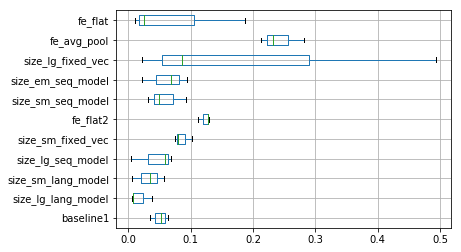

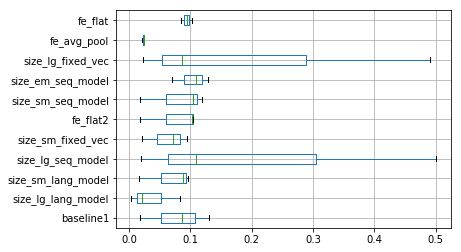

In [21]:
%matplotlib inline

from os import listdir
from pandas import read_csv
from pandas import DataFrame
from matplotlib import pyplot

# load all .csv results into a dataframe
train, test = DataFrame(), DataFrame()
directory = 'results'
for name in listdir(directory):
    if not name.endswith('csv'):
        continue
    filename = directory + '/' + name
    data = read_csv(filename, header=0)
    experiment = name.split('.')[0]
    train[experiment] = data['train']
    test[experiment] = data['test']

# plot results on train
train.boxplot(vert=False)
pyplot.show()
# plot results on test
test.boxplot(vert=False)
pyplot.show()